<a href="https://colab.research.google.com/github/antoinexp/markov-chains-COM-516/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is provided as a starting point to help you generate random instances G1 and G2 as mentioned in the handout.

You are free to use and modify it at your own convenience.

---



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scipy.stats as st
from scipy.spatial import ConvexHull
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import math
import random
from abc import ABC, abstractmethod

In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [4]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100

plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'

In [5]:
class DatasetGenerator(ABC):
    def __init__(self, N=100):
        self.N = N
        self.x = None
        self.v = None
        self.refresh()
    
    @abstractmethod
    def refresh(self):
        pass

In [6]:
class G1(DatasetGenerator):
    def refresh(self):
        self.x = np.random.rand(self.N, 2)
        self.v = np.random.rand(self.N)

In [7]:
class G2(DatasetGenerator):
    def refresh(self):
        self.x = np.random.rand(self.N, 2)
        self.v = np.exp(np.random.randn(self.N) * 1.3 - 0.85)

### Uniform distribution ($\mathcal U([0,1])$)

In [8]:
g1 = G1()

Examples:

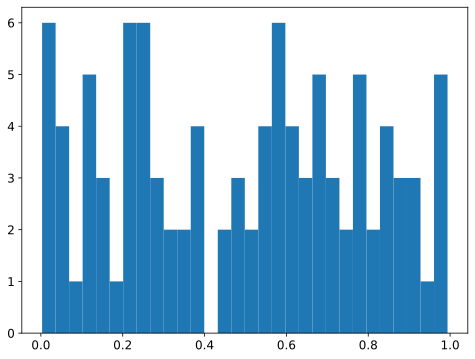

In [9]:
# Plot a histogram of the v array
plt.figure()
plt.hist(g1.v, bins=30)
plt.show()

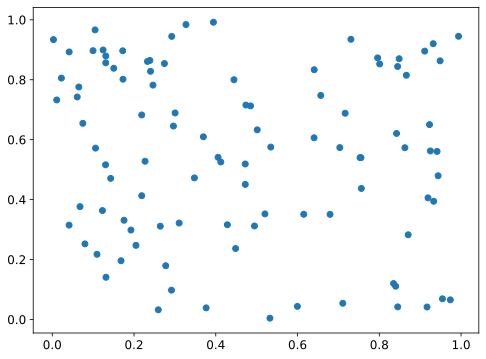

In [10]:
# plot the position of the points
plt.figure()
plt.scatter(g1.x[:,0], g1.x[:,1])
plt.show()

You can refresh the dataset

In [11]:
g1.refresh() # generate a new dataset

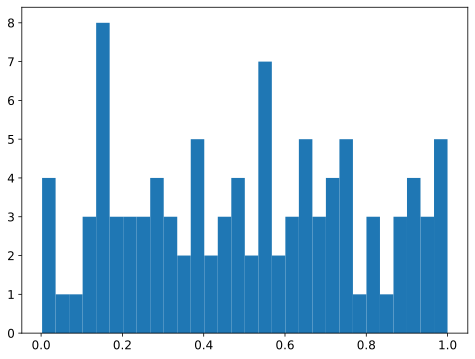

In [12]:
plt.figure()
plt.hist(g1.v, bins=30)
plt.show()

Or for instance, you can generate 10 instances and compute the average position of all the points:

In [13]:
m = np.array([0., 0.])

for _ in range(10):
    g1.refresh() # refresh the dataset
    m += 0.1*g1.x.mean()

print(m)

[0.50194293 0.50194293]


### Test on log-normal distribution

In [14]:
g2 = G2()

Example:

you can use g2 to generate an instance of the lognormal distribution

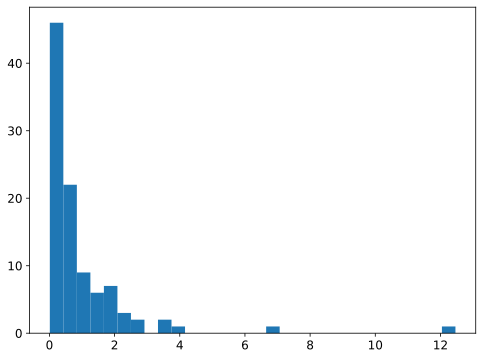

In [15]:
plt.figure()
plt.hist(g2.v, bins=30)
plt.show()

In [16]:
g2.refresh() # to generate a new x and v

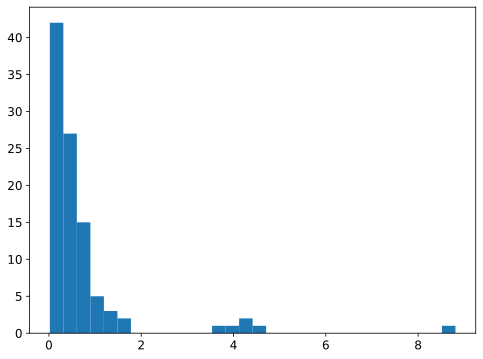

In [17]:
plt.figure()
plt.hist(g2.v, bins=30)
plt.show()

---

### Metropolis Hastings

In [18]:
from MH import minimize, maximize, optimizer
from numba import njit, prange

In [19]:
@njit(parallel=True)
def furtherest(index, array):
    n = len(index)
    ans = np.zeros((n, n))
    for i in prange(n):
        for j in prange(n):
            ans[i, j] = np.sqrt(np.sum(np.power((array[i] - array[j]), 2)))
    return np.max(ans)

def diameter(array):
    hull = ConvexHull(array, incremental=False)
    return furtherest(hull.vertices, array)

In [20]:
@maximize
def objective(v, x, lam, state):
    indicator = state
    n = len(indicator)
    assert len(v) == n
    assert x.shape == (n, 2)
    
    population = np.sum(v * indicator)
    
    cities = x[indicator]
    radius = diameter(cities) / 2
    area = math.pi * radius ** 2
    
    obj = population - lam * n * area
    return obj

def transition(state):
    ind = random.randint(0, len(state) - 1)
    new_state = np.copy(state)
    new_state[ind] = not state[ind]
    return new_state

In [21]:
g1 = G1(200)
g1.refresh()

In [22]:
lam = 0.5
beta = 0.5

In [23]:
inputs = {'v': g1.v, 'x': g1.x, 'lam': lam}
init_state = np.random.randint(0, 2, size=len(g1.v), dtype=bool)

In [24]:
optim = optimizer(objective, transition, beta, init_state, **inputs)

In [25]:
val = []
num_cities = []
num_iters = 2000
optim.reset()
for _ in range(num_iters):
    curr_state, curr_val = optim.step()
    val.append(curr_val)
    num_cities.append(np.sum(curr_state))

Text(0, 0.5, 'number')

<Figure size 640x480 with 0 Axes>

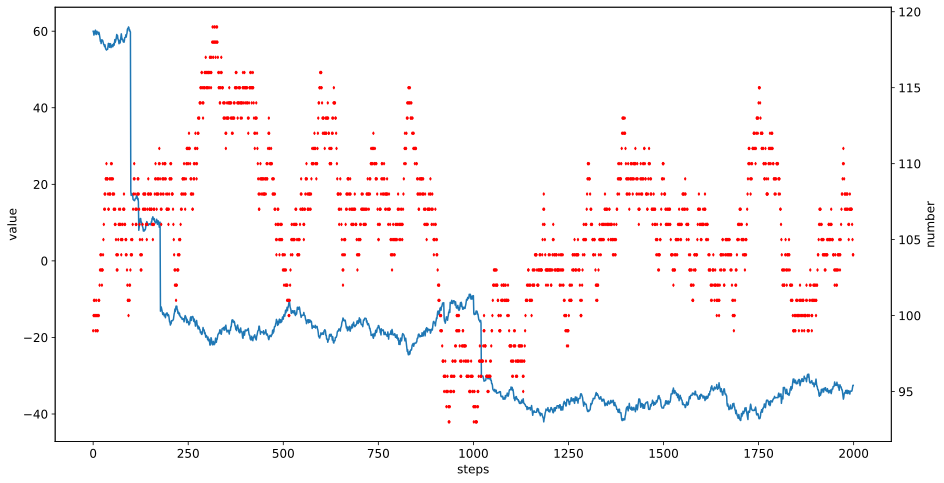

In [41]:
plt.clf()
steps = range(num_iters)
fig, ax1 = plt.subplots()
fig.set_size_inches(15, 8)
ax1.plot(range(num_iters), val, label='Objective function')
ax1.set_xlabel('steps')
ax1.set_ylabel('value')

ax2 = ax1.twinx()
ax2.scatter(range(num_iters), num_cities, s=3, marker='d', color='r', label='number of cities')
ax2.set_ylabel('number')